In [1]:
import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def pracuj():
    results = []
    existing_records = set()
    
    # url = "https://it.pracuj.pl/praca/krakow;wp?rd=0&et=17%2C4%2C18&sal=1&its=big-data-science"
    start = 1
    while True:
        url = f"https://it.pracuj.pl/praca/krakow;wp?rd=0&et=17%2C4%2C18&sal=1&pn={start}&its=big-data-science"
        response = requests.get(url, verify=True)
        if response.status_code != 200:
            raise Exception('Failed to load page {}'.format(url))
#         print("Strona:", start)
        doc = BeautifulSoup(response.text, 'html.parser')
        offers = doc.select('.c1s2myew .c1wygkax .core_n194fgoq')
#         offers = doc.select('.c1fljezf .core_n194fgoq')
        # print(offers)
        pages = [urljoin(url, link['href']) for link in offers if 'https://www.pracuj.pl/praca/' in link['href']]
#         print(pages)
        for page in pages:
            response = requests.get(page)
            if response.status_code != 200:
                raise Exception('Failed to load page {}'.format(page))
            doc = BeautifulSoup(response.text, 'html.parser')
            zrodlo = 'pracuj.pl'
            link = page
            stanowisko = doc.select('.offer-viewkHIhn3')[0].text
            firma = doc.select('.offer-viewwtdXJ4')[0].text
            minimalne = doc.select('.offer-viewiafL8R .offer-viewZGJhIB, .offer-viewYo2KTr')[0].text
            minimalne = minimalne.replace(',', '.')
            minimalne = re.sub(r'[^\d.]', '', minimalne)
            maksymalne = doc.select('.offer-viewYo2KTr')[0].text
            maksymalne = maksymalne.replace(',', '.')
            maksymalne = re.sub(r'[^\d.]', '', maksymalne)
#             print(maksymalne)

            stawka = doc.select('.offer-viewSGW6Yi')[0].text
            # minimalne = ''.join(filter(str.isdigit, minimalne))
            #wynagrodzenie powinno być podane jako kwota brutto: jeżeli podana jest stawka godzinowa netto, należy doliczyć VAT.

            if minimalne:
                if 'hr' in stawka or 'godz' in stawka:
                    if 'net' in stawka or 'netto' in stawka:
                        minimalne = float(minimalne)
                        minimalne *= 1.23 * 168
                        minimalne = int(minimalne)
                    else:
                        minimalne *=168
                else:
                    if 'net' in stawka or 'netto' in stawka:
                        minimalne = float(minimalne)
                        minimalne *= 1.23
                        minimalne = float(minimalne)
                    else:
                        minimalne = int(float(minimalne)) 
            else:
                minimalne = None
                
            if maksymalne:
                if 'hr' in stawka or 'godz' in stawka:
                    if 'net' in stawka or 'netto' in stawka:
                        maksymalne = float(maksymalne)
                        maksymalne *= 1.23 * 168
                        maksymalne = int(maksymalne)
                    else:
                        maksymalne *=168
                else:
                    if 'net' in stawka or 'netto' in stawka:
                        maksymalne = float(maksymalne)
                        maksymalne *= 1.23
                        maksymalne = float(maksymalne)
                    else:
                        maksymalne = int(float(maksymalne)) 
            else:
                maksymalne = None
            #
#             print(stanowisko)
#             print("Minimalna stawka:", minimalne)
#             print("Maksymalna stawka:", maksymalne)
#             print()

            waluta = "PLN"
            umiejetnosci = [umiejetnosc.text for umiejetnosc in doc.select('.offer-viewfjH4z3:first-of-type .offer-viewU0gxPf')]
            
            kategoria = doc.select('.offer-viewPFKc0t')[0].text #CZY TO RECZNIE WPISAC?
            seniority = doc.select('.offer-viewXo2dpV')[2].text
            seniorities = [seniority.strip() for seniority in seniority.split(',')]

            seniority_mapping = {
                'specialist (Mid / Regular)': 'Mid',
                'senior specialist (Senior)': 'Senior',
                'specialist (Mid / Regular)': 'Mid',
                'specjalista (Mid / Regular)': 'Mid',
                'starszy specjalista (Senior)': 'Senior',
                'senior specialist': 'Senior',
                'junior specialist (Junior)': 'Junior',
                'mÅodszy specjalista (Junior)': 'Junior',
                'specialist': 'Mid'
            }

            standardized_seniorities = [seniority_mapping.get(seniority, seniority) for seniority in seniorities if seniority in seniority_mapping]
            priority_order = ['Junior', 'Mid', 'Senior']

            sorted_seniorities = sorted(standardized_seniorities, key=lambda x: priority_order.index(x))

            seniority = ', '.join(sorted_seniorities)
            if ',' in seniority:
                second_seniority = seniority.split(',')[1].strip()
            else:
                second_seniority = seniority.strip()
                
            record_key = (zrodlo, link, stanowisko, firma, minimalne, maksymalne, waluta, tuple(umiejetnosci), kategoria, second_seniority)
            if record_key not in existing_records:
                existing_records.add(record_key)
                results.append({
                    'źródło': zrodlo,
                    'link': link,
                    'stanowisko': stanowisko,
                    'firma': firma,
                    'minimalne_wynagrodzenie': minimalne,
                    'maksymalne_wynagrodzenie': maksymalne,
                    'waluta': waluta,
                    'umiejetnosci': umiejetnosci,
                    'kategoria': kategoria,
                    'seniority': second_seniority,
                })

            
        start += 1
        if not pages:
            break
    return results
#         for result in results:
#             result['umiejetnosci'] = [skill.strip() for skill in result['umiejetnosci']]

#         output_file = 'praca_data.json'
#         with open(output_file, 'w', encoding='utf-8') as file:
#             json.dump(results, file, ensure_ascii=False, indent=4)        




In [3]:
#pracuj()

In [4]:
def justjoinit():
    results = []
    url = "https://justjoin.it/krakow/data/experience-level_junior.mid.senior/with-salary_yes"
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception('Failed to load page {}'.format(url))

    doc = BeautifulSoup(response.text, 'html.parser')
    offers = doc.select('.offer_list_offer_link.css-4lqp8g')
    # print(offers)
    pages = [urljoin(url, link['href']) for link in offers]
    #print(pages)
    for page in pages:
        response = requests.get(page)
        if response.status_code != 200:
            raise Exception('Failed to load page {}'.format(url))
            continue
        doc = BeautifulSoup(response.text, 'html.parser')
        zrodlo = 'justjoin.it'
        link = page
        stanowisko = doc.select('.css-vb54bv .css-1u65tlp')[0].text
        firma = doc.select('.css-mbkv7r')[0].text
        minimalne = doc.select('.css-1pavfqb')[0].text.split('-',1)[0]
        maksymalne  = doc.select('.css-1pavfqb')[0].text.split('-',1)[1].rstrip(' PLN')
        minimalne = minimalne.replace(" ", "")   
        maksymalne = maksymalne.replace(" ", "")   

        waluta = doc.select('.css-1pavfqb')[0].text.split(' ', 6)[5]
        umiejetnosci = [umiejetnosc.text for umiejetnosc in doc.select('h6.css-x1xnx3')]
        seniority = doc.select('.css-15wyzmd')[1].text #dopracowac z tymi podwojnymi pozimoami
        kategoria = doc.select('.css-6t6cyr')[0].text

        results.append({
            'źródło': zrodlo,
            'link': link,
            'stanowisko': stanowisko ,
            'firma': firma,
            'minimalne_wynagrodzenie' : minimalne ,
            'maksymalne_wynagrodzenie' : maksymalne,
            'waluta' : waluta,
            'umiejetnosci' : umiejetnosci ,
            'kategoria' : kategoria,
            'seniority' : seniority,
        })
    return results

#     for result in results:
#         result['umiejetnosci'] = [skill.strip() for skill in result['umiejetnosci']]

#     output_file = 'jobs_data.json'
#     with open(output_file, 'w', encoding='utf-8') as file:
#         json.dump(results, file, ensure_ascii=False, indent=4)

#     print(f"Dane ofert pracy zostały zapisane do pliku: {output_file}")




In [5]:
#justjoinit()

In [6]:
wyniki_pracuj = pracuj()  
wyniki_justjoin = justjoinit()

wszystkie_wyniki = wyniki_pracuj + wyniki_justjoin 

In [7]:
#wszystkie_wyniki

In [8]:
output_file = 'all_data.json'
with open(output_file, 'w', encoding='utf-8') as file:
    json.dump(wszystkie_wyniki, file, ensure_ascii=False, indent=4)   

# UMIEJETNOSCI

In [9]:
skills_count = {}
for oferta in wszystkie_wyniki: 
    umiejetnosci_oferty = oferta['umiejetnosci']
    for skill in umiejetnosci_oferty:
        if skill in skills_count:
            skills_count[skill] += 1
        else:
            skills_count[skill] = 1

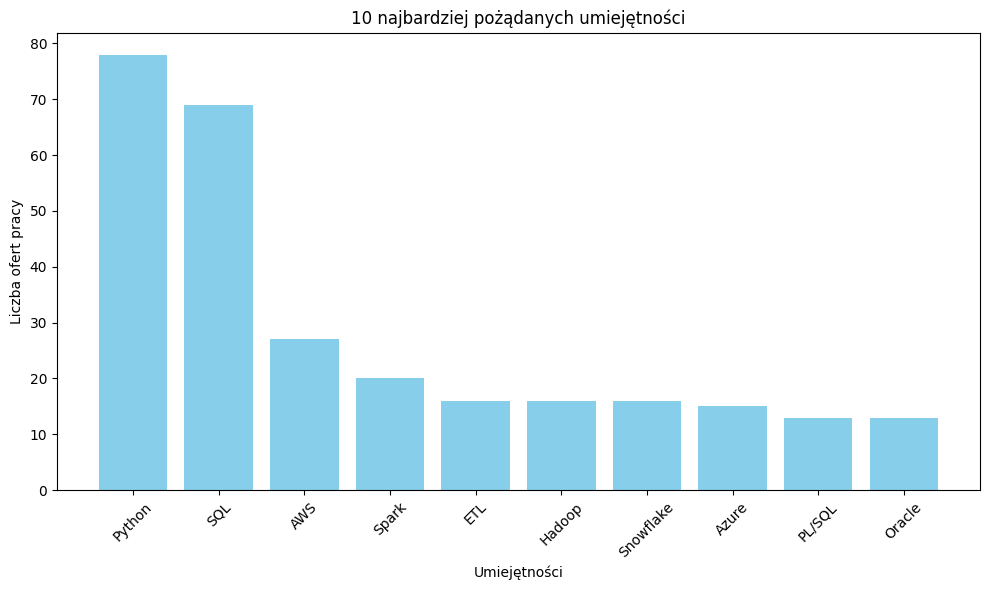

In [10]:
sorted_skills_count = dict(sorted(skills_count.items(), key=lambda item: item[1], reverse=True))
top_skills = dict(list(sorted_skills_count.items())[:10])

plt.figure(figsize=(10, 6))
plt.bar(top_skills.keys(), top_skills.values(), color='skyblue')
plt.title('10 najbardziej pożądanych umiejętności')
plt.xlabel('Umiejętności')
plt.xticks(rotation=45)
plt.ylabel('Liczba ofert pracy')

plt.tight_layout()
plt.show()

In [11]:
report_data = {
    'Wszystkie_umiejętności': sorted_skills_count
}

with open('raport_umiejetnosci.json', 'w') as file:
    json.dump(report_data, file)

In [12]:
# poszukiwane_stanowiska = [
#     'Junior Data Engineer',
#     'Junior Data Analyst',
#     'Junior Data Architect',
#     'Junior Data Scientist',
#     'Mid/Regular Data Analyst',
#     'Mid/Regular Data Scientist',
#     'Mid/Regular Data Engineer',
#     'Mid/Regular Data Architect',
#     'Senior Data Engineer',
#     'Senior Data Analyst',
#     'Senior Data Scientist',
#     'Senior Data Architect'
# ]

In [13]:
# for oferta in wszystkie_wyniki:
#     if 'junior' not in oferta['stanowisko'].lower() and 'senior' not in oferta['stanowisko'].lower() and 'mid' not in oferta['stanowisko'].lower():
#         oferta['stanowisko'] = f"{oferta['seniority']} " + oferta['stanowisko']

In [14]:
for oferta in wszystkie_wyniki:
    if 'junior' not in oferta['stanowisko'].lower() and 'senior' not in oferta['stanowisko'].lower() and 'mid' not in oferta['stanowisko'].lower():
        oferta['zmodyfikowane_stanowisko'] = f"{oferta['seniority']} " + oferta['stanowisko']
    else:
        oferta['zmodyfikowane_stanowisko'] = oferta['stanowisko']

In [15]:
stanowiska = {
    'Junior Data Engineer': [],  #++ 
    'Mid/Regular Data Engineer': [], #++
    'Senior Data Engineer': [], #++
    'Junior Data Analyst': [], #++
    'Mid/Regular Data Analyst': [], #++
    'Senior Data Analyst': [], #++
    'Junior Data Scientist': [], #++
    'Mid/Regular Data Scientist': [],
    'Senior Data Scientist': [],  #++
    'Junior Data Architect': [], #++
    'Mid/Regular Data Architect': [], #++
    'Senior Data Architect': [] #++
}
for oferta in wszystkie_wyniki:
    zmodyfikowane_stanowisko = oferta['zmodyfikowane_stanowisko']
    minimalne_wynagrodzenie = float(oferta['minimalne_wynagrodzenie'])
    maksymalne_wynagrodzenie = float(oferta['maksymalne_wynagrodzenie'])

    if zmodyfikowane_stanowisko:
        if 'junior data engineer' in zmodyfikowane_stanowisko.lower():
            stanowiska['Junior Data Engineer'].append((minimalne_wynagrodzenie, maksymalne_wynagrodzenie))
            
        if 'senior data engineer' in zmodyfikowane_stanowisko.lower():
            stanowiska['Senior Data Engineer'].append((minimalne_wynagrodzenie, maksymalne_wynagrodzenie))
            
        if 'senior data architect' in zmodyfikowane_stanowisko.lower():
            stanowiska['Senior Data Architect'].append((minimalne_wynagrodzenie, maksymalne_wynagrodzenie))
            
        if 'junior data architect' in zmodyfikowane_stanowisko.lower():
            stanowiska['Junior Data Architect'].append((minimalne_wynagrodzenie, maksymalne_wynagrodzenie))
            
        if 'junior data scientist' in zmodyfikowane_stanowisko.lower():
            stanowiska['Junior Data Scientist'].append((minimalne_wynagrodzenie, maksymalne_wynagrodzenie))    
        
        if 'senior data analyst' in zmodyfikowane_stanowisko.lower():
            stanowiska['Senior Data Analyst'].append((minimalne_wynagrodzenie, maksymalne_wynagrodzenie))
            
        if 'junior data analyst' in zmodyfikowane_stanowisko.lower():
            stanowiska['Junior Data Analyst'].append((minimalne_wynagrodzenie, maksymalne_wynagrodzenie))
            
        if 'senior data scientist' in zmodyfikowane_stanowisko.lower():
            stanowiska['Senior Data Scientist'].append((minimalne_wynagrodzenie, maksymalne_wynagrodzenie)) 
            
        if 'mid data analyst' in zmodyfikowane_stanowisko.lower():
            stanowiska['Mid/Regular Data Analyst'].append((minimalne_wynagrodzenie, maksymalne_wynagrodzenie)) 
        
        if 'mid data architect' in zmodyfikowane_stanowisko.lower():
            stanowiska['Mid/Regular Data Architect'].append((minimalne_wynagrodzenie, maksymalne_wynagrodzenie)) 
            
        if 'mid data engineer' in zmodyfikowane_stanowisko.lower():
            stanowiska['Mid/Regular Data Engineer'].append((minimalne_wynagrodzenie, maksymalne_wynagrodzenie)) 
                
        if 'mid data scientist' in zmodyfikowane_stanowisko.lower():
            stanowiska['Mid/Regular Data Scientist'].append((minimalne_wynagrodzenie, maksymalne_wynagrodzenie))
            
for stanowisko, wynagrodzenia in stanowiska.items():
    if wynagrodzenia:
        minimalne = min(wynagrodzenia, key=lambda x: x[0])[0]
        maksymalne = max(wynagrodzenia, key=lambda x: x[1])[1]
        srednie = sum((minimalne, maksymalne)) / 2

#         print(f"Stanowisko: {stanowisko}")
#         print(f"Minimalne wynagrodzenie: {minimalne}")
#         print(f"Maksymalne wynagrodzenie: {maksymalne}")
#         print(f"Średnie wynagrodzenie: {srednie}\n")


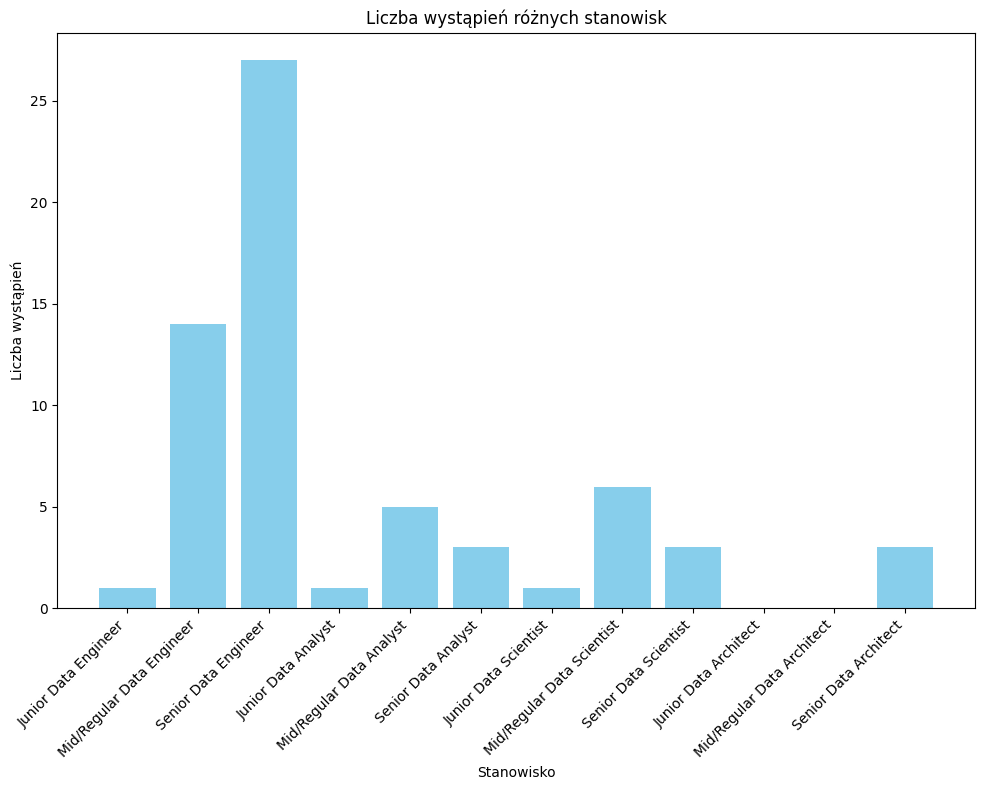

In [16]:
licznik_stanowisk = {stanowisko: len(wynagrodzenia) for stanowisko, wynagrodzenia in stanowiska.items()}

fig, axes = plt.subplots(figsize=(10, 8))

plt.bar(licznik_stanowisk.keys(), licznik_stanowisk.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Liczba wystąpień różnych stanowisk')
plt.xlabel('Stanowisko')
plt.ylabel('Liczba wystąpień')
plt.tight_layout()
plt.show()

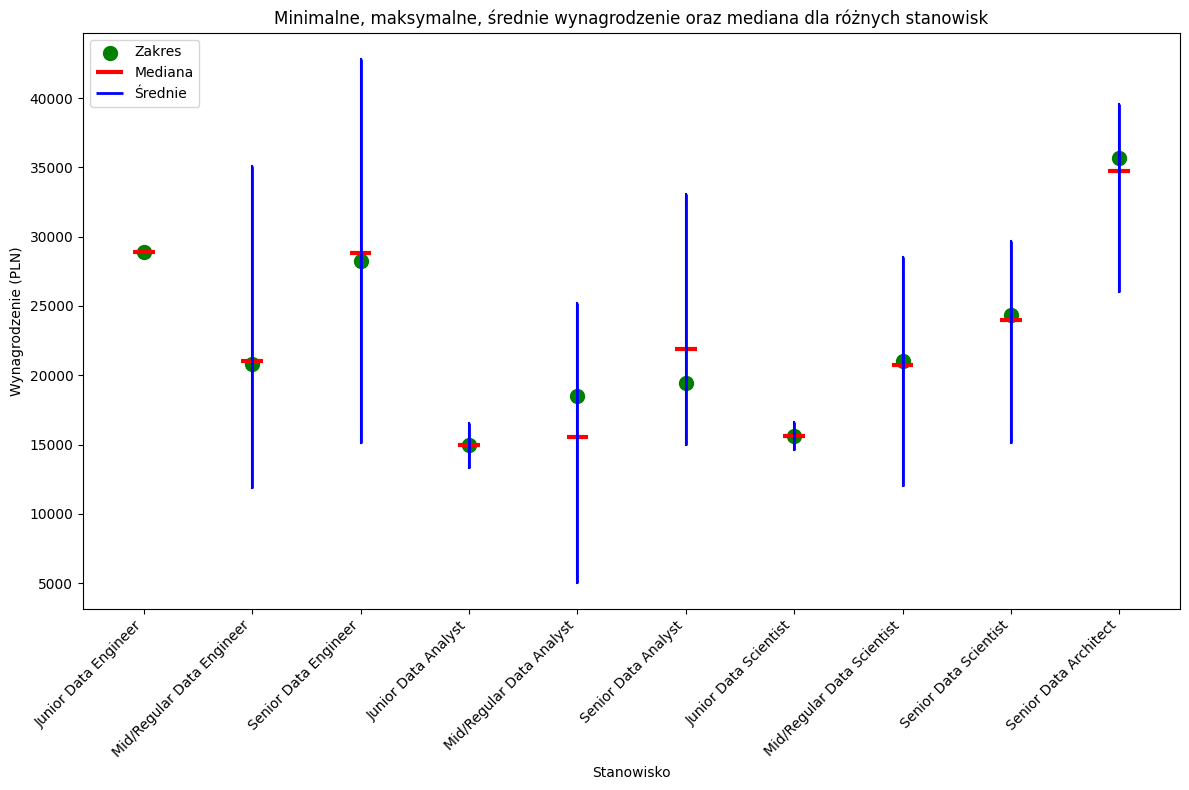

In [17]:
statystyki_wynagrodzen = {}
for stanowisko, wynagrodzenia in stanowiska.items():
    if wynagrodzenia:
        minimalne = min(wyn[0] for wyn in wynagrodzenia)
        maksymalne = max(wyn[1] for wyn in wynagrodzenia)
        srednie = sum((sum(wyn) / 2 for wyn in wynagrodzenia)) / len(wynagrodzenia)
        median = sorted([wyn[0] + (wyn[1] - wyn[0]) / 2 for wyn in wynagrodzenia])[len(wynagrodzenia) // 2]
    else:
        continue 
    statystyki_wynagrodzen[stanowisko] = {'Minimalne': minimalne, 'Maksymalne': maksymalne, 'Średnie': srednie, 'Mediana': median}

fig, ax = plt.subplots(figsize=(12, 8))

stanowiska_labels = list(statystyki_wynagrodzen.keys())
minimalne_wynagrodzenia = [dane['Minimalne'] for dane in statystyki_wynagrodzen.values()]
maksymalne_wynagrodzenia = [dane['Maksymalne'] for dane in statystyki_wynagrodzen.values()]
srednie_wynagrodzenia = [dane['Średnie'] for dane in statystyki_wynagrodzen.values()]
mediany_wynagrodzenia = [dane['Mediana'] for dane in statystyki_wynagrodzen.values()]

for i, (min_w, max_w, srednie_w, median_w) in enumerate(zip(minimalne_wynagrodzenia, maksymalne_wynagrodzenia, srednie_wynagrodzenia, mediany_wynagrodzenia)):
    ax.plot([i, i], [min_w, max_w], color='blue', linestyle='-', label='_nolegend_')
    ax.scatter(i, median_w, color='green', marker='o', s=100, label='Mediana' if i == 0 else '_nolegend_')
    if srednie_w != 0:
        ax.hlines(y=srednie_w, xmin=i - 0.1, xmax=i + 0.1, color='red', linewidth=3, label='Średnie' if i == 0 else '_nolegend_')
    
    ax.vlines(x=i, ymin=min_w, ymax=max_w, colors='blue', linewidth=2, label='Zakres' if i == 0 else '_nolegend_')


ax.set_xticks(range(len(stanowiska_labels)))
ax.set_xticklabels(stanowiska_labels, rotation=45, ha='right')
ax.set_title('Minimalne, maksymalne, średnie wynagrodzenie oraz mediana dla różnych stanowisk')
ax.set_xlabel('Stanowisko')
ax.set_ylabel('Wynagrodzenie (PLN)')

handles, labels = ax.get_legend_handles_labels()
unique_labels = set(labels)
ax.legend(handles, unique_labels)

plt.tight_layout()
plt.show()


In [18]:
for stanowisko, wynagrodzenia in stanowiska.items():
    if wynagrodzenia:
        minimalne = min(wynagrodzenia, key=lambda x: x[0])[0]
        maksymalne = max(wynagrodzenia, key=lambda x: x[1])[1]
        srednie = sum((minimalne, maksymalne)) / 2
        stanowiska[stanowisko] = {
            'Ilość ofert': len(wynagrodzenia),
            'Wynagrodzenie minimalne': minimalne,
            'Wynagrodzenie maksymalne': maksymalne,
            'Średnie wynagrodzenie': srednie
        }

with open('raport_stanowisk.json', 'w') as file:
    json.dump(stanowiska, file)